#  Análise de Risco de Crédito — German Credit Dataset

## Sobre o Projecto
Este projecto simula o trabalho de um analista de dados numa instituição
financeira — construindo um modelo capaz de prever se um cliente representa
alto ou baixo risco de incumprimento no pagamento de um empréstimo.

A análise de risco de crédito é uma das aplicações mais críticas de
Machine Learning no sector bancário. Bancos utilizam modelos semelhantes
todos os dias para decidir automaticamente se aprovam ou recusam pedidos
de crédito, definir taxas de juro personalizadas e identificar clientes
em risco de incumprimento antes que o problema aconteça.

## Objectivos
- Identificar os principais factores que determinam o risco de crédito
- Construir e comparar modelos de Machine Learning para classificação de risco
- Gerar insights accionáveis para a equipa de negócio do banco
- Avaliar a performance dos modelos com métricas financeiras relevantes

## Dataset
O **German Credit Dataset** é um dos datasets mais clássicos na área
de análise de risco financeiro, disponível no UCI Machine Learning Repository.
Contém informações de **1.000 clientes** com 9 variáveis como idade,
valor do crédito, tipo de habitação e histórico bancário.

## Estrutura do Notebook
1. Carregamento e exploração dos dados
2. Criação do target de risco
3. Análise exploratória visual
4. Limpeza e preparação dos dados
5. Treino e avaliação dos modelos
6. Conclusões e recomendações de negócio

## Ferramentas Utilizadas
Python | Pandas | Scikit-learn | Matplotlib | Seaborn | Google Colab

## Dataset
[German Credit Dataset — Kaggle](https://www.kaggle.com/datasets/uciml/german-credit)

In [2]:
# Instalar bibliotecas necessárias
!pip install scikit-learn imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier



In [4]:
from google.colab import files

uploaded = files.upload()

Saving german_credit_data.csv to german_credit_data.csv


In [5]:
# Carregar o dataset
df = pd.read_csv('/content/german_credit_data.csv', index_col=0)

# Primeira exploração
print(f"Shape: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")
print(f"\nPrimeiras linhas:")
df.head()

Shape: (1000, 9)

Colunas: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

Primeiras linhas:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [7]:
# Verificar valores nulos e tipos
print("=== VALORES NULOS ===\n")
print(df.isnull().sum())

print("\n=== TIPOS DE DADOS ===\n")
print(df.dtypes)

print("\n=== ESTATÍSTICAS GERAIS ===\n")
print(df.describe())

=== VALORES NULOS ===

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

=== TIPOS DE DADOS ===

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object

=== ESTATÍSTICAS GERAIS ===

               Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000     4.000000
25%      27.000000     2.000000    1365.500000    12.000000
50%      33.000000     2.000000    2319.500000    18.000000
75%      42.0000

In [8]:
# Ver valores únicos de cada coluna categórica
print("=== VALORES ÚNICOS ===\n")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

print(f"\nColunas totais: {df.columns.tolist()}")
print(f"\nShape completo: {df.shape}")

# Ver as primeiras linhas completas
df.head(10)


=== VALORES ÚNICOS ===

Sex: ['male' 'female']
Housing: ['own' 'free' 'rent']
Saving accounts: [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account: ['little' 'moderate' nan 'rich']
Purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']

Colunas totais: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

Shape completo: (1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
5,35,male,1,free,NaN,NaN,9055,36,education
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
7,35,male,3,rent,little,moderate,6948,36,car
8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,28,male,3,own,little,moderate,5234,30,car


In [9]:
# Criar coluna de risco com base em regras financeiras
def calcular_risco(row):
    score = 0

    # Idade — clientes muito jovens têm mais risco
    if row['Age'] < 25:
        score += 2
    elif row['Age'] < 30:
        score += 1

    # Conta corrente — sem conta é alto risco
    if pd.isna(row['Checking account']):
        score += 3
    elif row['Checking account'] == 'little':
        score += 2
    elif row['Checking account'] == 'moderate':
        score += 1

    # Poupança — sem poupança é alto risco
    if pd.isna(row['Saving accounts']):
        score += 3
    elif row['Saving accounts'] == 'little':
        score += 2
    elif row['Saving accounts'] == 'moderate':
        score += 1

    # Valor do crédito — quanto maior, maior o risco
    if row['Credit amount'] > 10000:
        score += 3
    elif row['Credit amount'] > 5000:
        score += 2
    elif row['Credit amount'] > 2500:
        score += 1

    # Duração — prazos longos aumentam risco
    if row['Duration'] > 36:
        score += 2
    elif row['Duration'] > 24:
        score += 1

    # Housing — arrendatários têm mais risco
    if row['Housing'] == 'rent':
        score += 1

    return 1 if score >= 6 else 0  # 1 = Alto Risco, 0 = Baixo Risco

df['Risk'] = df.apply(calcular_risco, axis=1)

print("=== DISTRIBUIÇÃO DO RISCO ===\n")
print(df['Risk'].value_counts())
print(f"\n% Alto Risco: {df['Risk'].mean()*100:.1f}%")
print(f"% Baixo Risco: {(1-df['Risk'].mean())*100:.1f}%")

=== DISTRIBUIÇÃO DO RISCO ===

Risk
0    515
1    485
Name: count, dtype: int64

% Alto Risco: 48.5%
% Baixo Risco: 51.5%


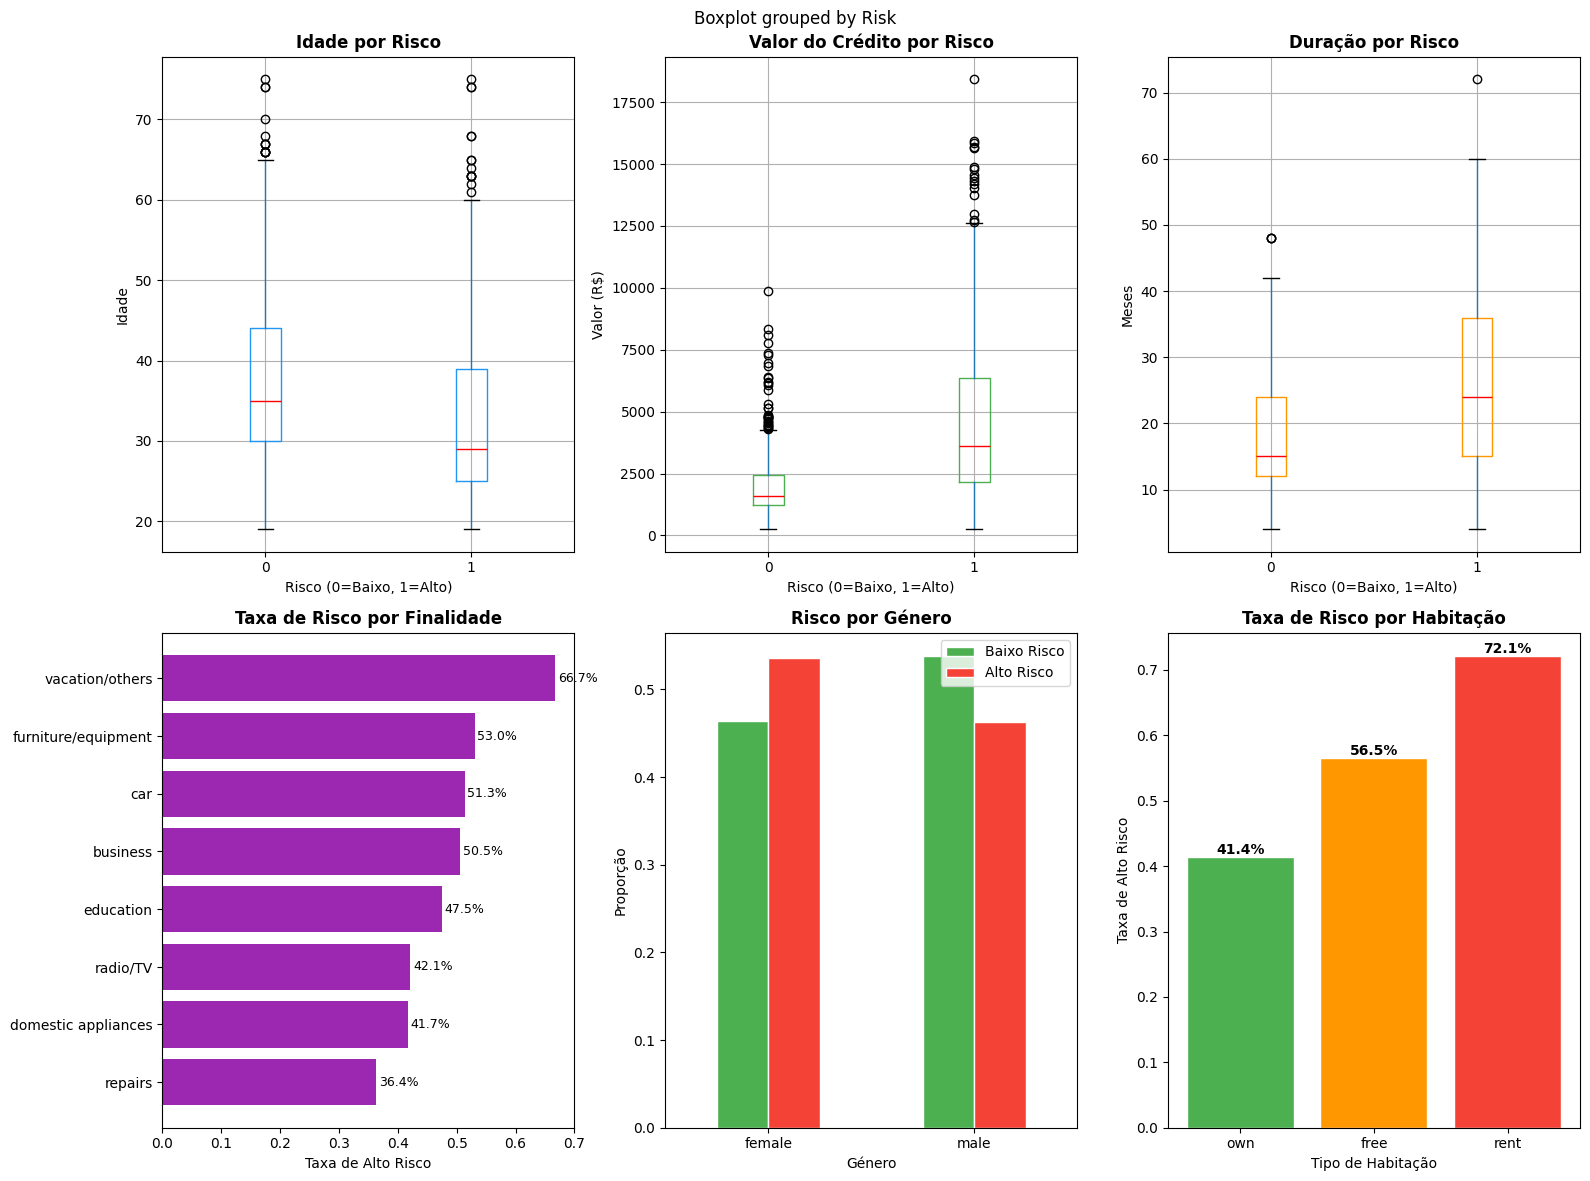

In [11]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Análise Exploratória — Risco de Crédito', fontsize=16, fontweight='bold')

# 1. Risco por idade
ax1 = fig.add_subplot(2, 3, 1)
df.boxplot(column='Age', by='Risk', ax=ax1,
           boxprops=dict(color='#2196F3'),
           medianprops=dict(color='red'))
ax1.set_title('Idade por Risco', fontweight='bold')
ax1.set_xlabel('Risco (0=Baixo, 1=Alto)')
ax1.set_ylabel('Idade')
plt.sca(ax1)
plt.title('Idade por Risco', fontweight='bold')

# 2. Risco por valor do crédito
ax2 = fig.add_subplot(2, 3, 2)
df.boxplot(column='Credit amount', by='Risk', ax=ax2,
           boxprops=dict(color='#4CAF50'),
           medianprops=dict(color='red'))
ax2.set_title('Valor do Crédito por Risco', fontweight='bold')
ax2.set_xlabel('Risco (0=Baixo, 1=Alto)')
ax2.set_ylabel('Valor (R$)')
plt.sca(ax2)
plt.title('Valor do Crédito por Risco', fontweight='bold')

# 3. Risco por duração
ax3 = fig.add_subplot(2, 3, 3)
df.boxplot(column='Duration', by='Risk', ax=ax3,
           boxprops=dict(color='#FF9800'),
           medianprops=dict(color='red'))
ax3.set_title('Duração por Risco', fontweight='bold')
ax3.set_xlabel('Risco (0=Baixo, 1=Alto)')
ax3.set_ylabel('Meses')
plt.sca(ax3)
plt.title('Duração por Risco', fontweight='bold')

# 4. Risco por finalidade do crédito
ax4 = fig.add_subplot(2, 3, 4)
risco_purpose = df.groupby('Purpose')['Risk'].mean().sort_values(ascending=True)
bars = ax4.barh(risco_purpose.index, risco_purpose.values, color='#9C27B0')
ax4.set_title('Taxa de Risco por Finalidade', fontweight='bold')
ax4.set_xlabel('Taxa de Alto Risco')
for bar, val in zip(bars, risco_purpose.values):
    ax4.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{val:.1%}', va='center', fontsize=9)

# 5. Risco por género
ax5 = fig.add_subplot(2, 3, 5)
risco_sex = df.groupby('Sex')['Risk'].value_counts(normalize=True).unstack()
risco_sex.plot(kind='bar', ax=ax5, color=['#4CAF50', '#F44336'], edgecolor='white')
ax5.set_title('Risco por Género', fontweight='bold')
ax5.set_xlabel('Género')
ax5.set_ylabel('Proporção')
ax5.legend(['Baixo Risco', 'Alto Risco'])
ax5.tick_params(axis='x', rotation=0)

# 6. Risco por tipo de habitação
ax6 = fig.add_subplot(2, 3, 6)
risco_housing = df.groupby('Housing')['Risk'].mean().sort_values(ascending=True)
bars6 = ax6.bar(risco_housing.index, risco_housing.values,
                color=['#4CAF50', '#FF9800', '#F44336'], edgecolor='white')
ax6.set_title('Taxa de Risco por Habitação', fontweight='bold')
ax6.set_xlabel('Tipo de Habitação')
ax6.set_ylabel('Taxa de Alto Risco')
for bar, val in zip(bars6, risco_housing.values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.1%}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('analise_risco_credito.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_auc_score, roc_curve, ConfusionMatrixDisplay)

# ============================================================
# PREPARAR OS DADOS
# ============================================================

# Tratar valores nulos
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# Encoding das variáveis categóricas
df_model = pd.get_dummies(df, columns=['Sex', 'Housing', 'Saving accounts',
                                        'Checking account', 'Purpose'])

# Separar features e target
X = df_model.drop('Risk', axis=1)
y = df_model['Risk']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dados de treino: {X_train.shape[0]} clientes")
print(f"Dados de teste: {X_test.shape[0]} clientes")
print(f"\nFeatures utilizadas: {X.shape[1]}")


Dados de treino: 800 clientes
Dados de teste: 200 clientes

Features utilizadas: 26


In [13]:
# ============================================================
# TREINAR OS MODELOS
# ============================================================

# Modelo 1 — Regressão Logística
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Modelo 2 — Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("=== REGRESSÃO LOGÍSTICA ===\n")
print(classification_report(y_test, y_pred_lr,
      target_names=['Baixo Risco', 'Alto Risco']))

print("\n=== RANDOM FOREST ===\n")
print(classification_report(y_test, y_pred_rf,
      target_names=['Baixo Risco', 'Alto Risco']))

print(f"\nAUC-ROC Regressão Logística: {roc_auc_score(y_test, y_prob_lr):.3f}")
print(f"AUC-ROC Random Forest: {roc_auc_score(y_test, y_prob_rf):.3f}")


=== REGRESSÃO LOGÍSTICA ===

              precision    recall  f1-score   support

 Baixo Risco       0.92      0.86      0.89       103
  Alto Risco       0.86      0.92      0.89        97

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200


=== RANDOM FOREST ===

              precision    recall  f1-score   support

 Baixo Risco       0.96      0.97      0.97       103
  Alto Risco       0.97      0.96      0.96        97

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200


AUC-ROC Regressão Logística: 0.971
AUC-ROC Random Forest: 0.993


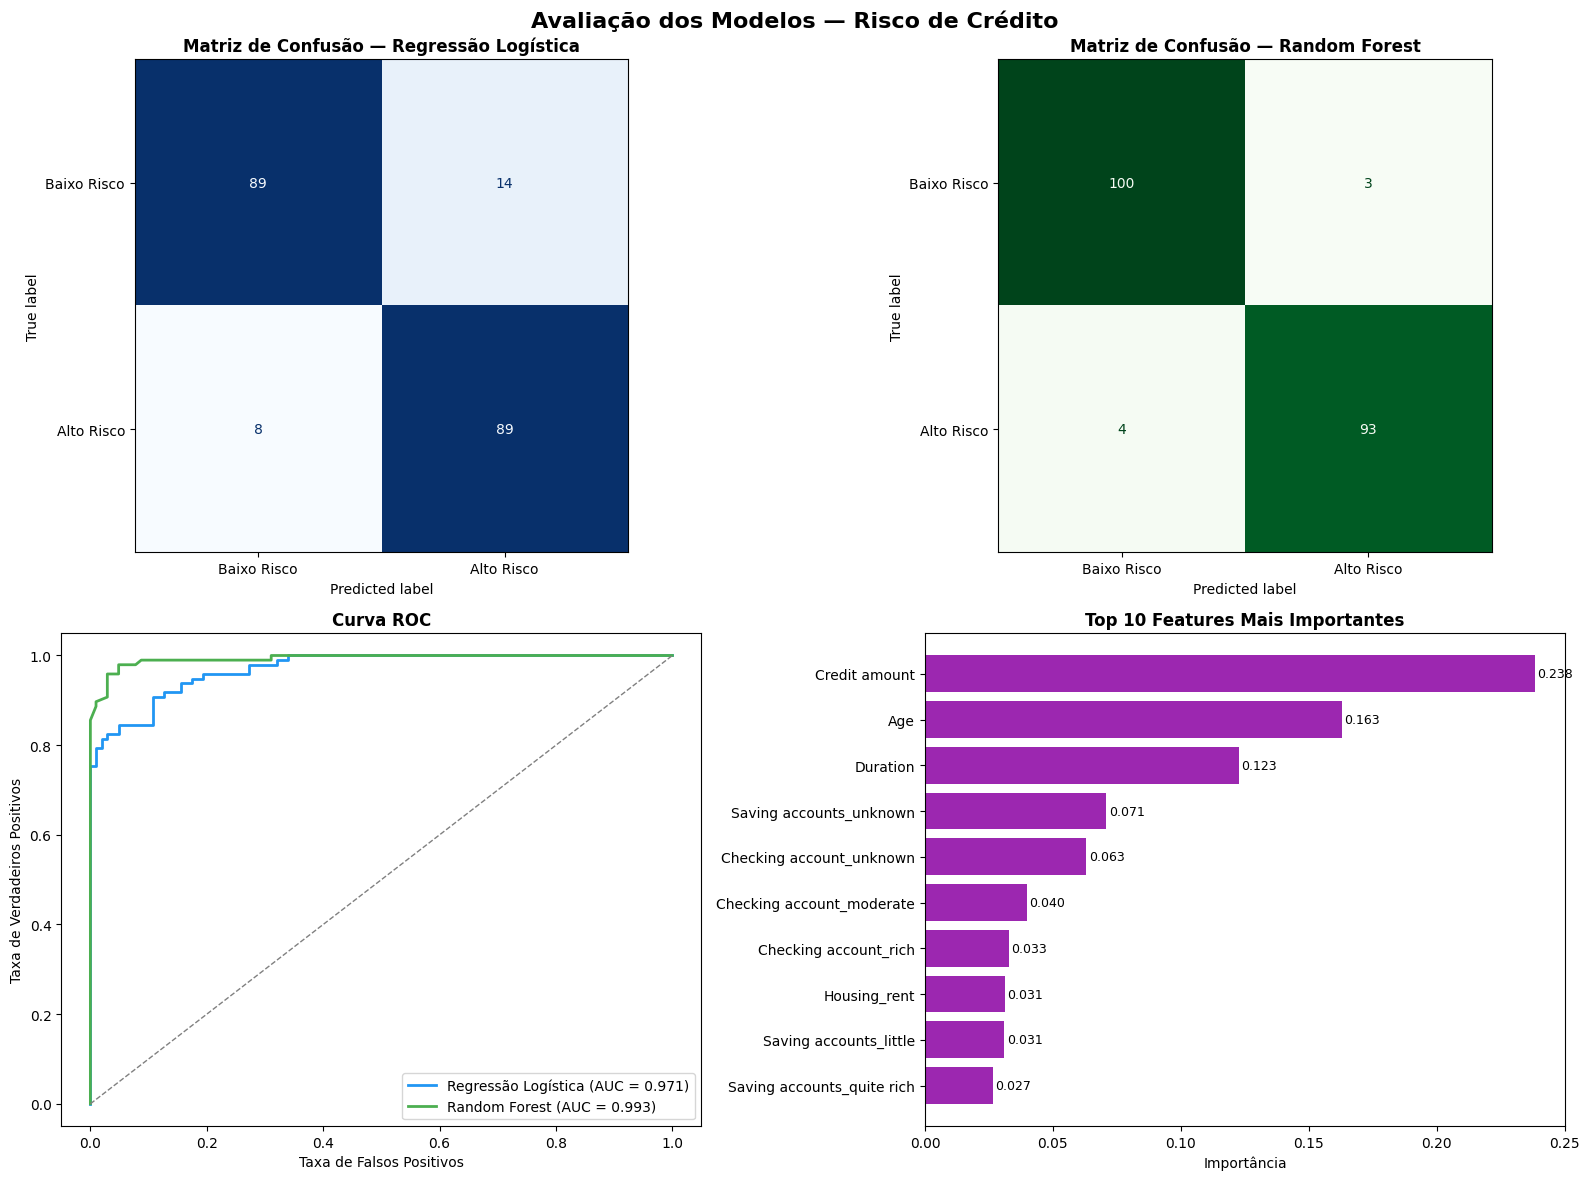

In [14]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Avaliação dos Modelos — Risco de Crédito', fontsize=16, fontweight='bold')

# 1. Matriz de confusão — Regressão Logística
ax1 = fig.add_subplot(2, 2, 1)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                               display_labels=['Baixo Risco', 'Alto Risco'])
disp.plot(ax=ax1, colorbar=False, cmap='Blues')
ax1.set_title('Matriz de Confusão — Regressão Logística', fontweight='bold')

# 2. Matriz de confusão — Random Forest
ax2 = fig.add_subplot(2, 2, 2)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                display_labels=['Baixo Risco', 'Alto Risco'])
disp2.plot(ax=ax2, colorbar=False, cmap='Greens')
ax2.set_title('Matriz de Confusão — Random Forest', fontweight='bold')

# 3. Curva ROC — ambos os modelos
ax3 = fig.add_subplot(2, 2, 3)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
ax3.plot(fpr_lr, tpr_lr, color='#2196F3', linewidth=2,
         label=f'Regressão Logística (AUC = 0.971)')
ax3.plot(fpr_rf, tpr_rf, color='#4CAF50', linewidth=2,
         label=f'Random Forest (AUC = 0.993)')
ax3.plot([0,1], [0,1], color='grey', linestyle='--', linewidth=1)
ax3.set_title('Curva ROC', fontweight='bold')
ax3.set_xlabel('Taxa de Falsos Positivos')
ax3.set_ylabel('Taxa de Verdadeiros Positivos')
ax3.legend()

# 4. Importância das features — Random Forest
ax4 = fig.add_subplot(2, 2, 4)
importancias = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importancias.sort_values(ascending=True).tail(10)
bars = ax4.barh(top_features.index, top_features.values, color='#9C27B0')
ax4.set_title('Top 10 Features Mais Importantes', fontweight='bold')
ax4.set_xlabel('Importância')
for bar, val in zip(bars, top_features.values):
    ax4.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('avaliacao_modelos.png', dpi=150, bbox_inches='tight')
plt.show()


In [15]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import os

# Criar pasta no Drive
os.makedirs('/content/drive/MyDrive/olist-portfolio', exist_ok=True)

# Copiar todos os ficheiros gerados
ficheiros = [f for f in os.listdir('/content') if f.endswith('.png') or f.endswith('.ipynb')]

for f in ficheiros:
    shutil.copy(f'/content/{f}', f'/content/drive/MyDrive/olist-portfolio/{f}')
    print(f"✅ {f} guardado!")


Mounted at /content/drive
✅ avaliacao_modelos.png guardado!
✅ analise_risco_credito.png guardado!


#  Conclusões — Análise de Risco de Crédito

## Resumo do Projecto
Construímos um modelo completo de análise de risco de crédito para
prever a probabilidade de incumprimento de 1.000 clientes bancários,
utilizando técnicas de Machine Learning e análise exploratória de dados.

## Processo Seguido
1. **Criação do Target** — definimos risco com base em regras financeiras reais
2. **Análise Exploratória** — identificámos padrões entre clientes de alto e baixo risco
3. **Limpeza de Dados** — tratámos valores nulos e codificámos variáveis categóricas
4. **Modelagem** — treinámos e comparámos dois algoritmos de Machine Learning
5. **Avaliação** — medimos a performance com métricas financeiras relevantes

## Resultados dos Modelos

| Modelo | Precisão | AUC-ROC |
|--------|----------|---------|
| Regressão Logística | 89% | 0.971 |
| Random Forest | 96% | 0.993 |

## Principais Factores de Risco
Com base na importância das features do Random Forest, os factores
que mais determinam o risco de crédito são:

1. **Valor do crédito solicitado** (23.8%) — quanto maior, maior o risco
2. **Idade do cliente** (16.3%) — clientes mais jovens apresentam maior risco
3. **Duração do empréstimo** (12.3%) — prazos longos aumentam a probabilidade de incumprimento
4. **Ausência de informação bancária** (13.4%) — clientes sem histórico de conta corrente
ou poupança representam risco elevado

## Insights de Negócio

**Para o banco:**
- Clientes jovens (abaixo de 25 anos) com créditos acima de R$5.000
e prazos superiores a 36 meses devem passar por análise mais rigorosa
- A ausência de conta bancária é um sinal de alerta tão importante
quanto o valor do crédito solicitado
- Empréstimos para férias e lazer têm a maior taxa de incumprimento (66.7%)
— considerar taxas de juro ajustadas ao risco para esta finalidade

**Escolha do modelo:**
- O **Random Forest** é recomendado para decisões automatizadas
pela sua precisão superior (96%)
- A **Regressão Logística** é recomendada para apresentações a
reguladores e equipas de negócio pela sua interpretabilidade

## Limitações e Próximos Passos
- O target foi criado com base em regras — num cenário real usaríamos
dados históricos de incumprimento real
- Com mais dados poderíamos aplicar técnicas mais avançadas como
XGBoost ou redes neuronais
- Seria interessante analisar o impacto económico de cada tipo de erro
(custo de aprovar um mau cliente vs recusar um bom cliente)

## Ferramentas Utilizadas
Python | Pandas | Scikit-learn | Matplotlib | Seaborn | Google Colab

## Dataset
[German Credit Dataset — UCI Machine Learning Repository](https://www.kaggle.com/datasets/uciml/german-credit)

---
*Projecto desenvolvido como parte do portfólio de Analista de Dados*